In [ ]:
import pandas as pd
import numpy as np
import zipfile
import re
import os
from scipy.spatial import KDTree

TYP_ZIP_FILE = '/content/typ.zip'
EXO_ZIP_FILE = '/content/exo.zip'
LABELS_FILE = '/content/labels.csv'
TEST_FILE = '/content/test.csv'
OUTPUT_FILE = '/content/cleaned_labels.csv'

In [ ]:
!mkdir -p /content/images/
!unzip -q /content/typ.zip -d /content/images/
!unzip -q /content/exo.zip -d /content/images/

In [ ]:
def get_image_file_data(zip_files):

    image_data = []

    coord_pattern = re.compile(r'^([\d\.-]+)\s([\d\.-]+)_\[.*\.png$')

    print(f"Scanning zip files: {zip_files}")
    for zip_name in zip_files:
        if not os.path.exists(zip_name):
            print(f"Warning: Zip file not found: {zip_name}")
            continue

        with zipfile.ZipFile(zip_name, 'r') as zf:
            for filepath in zf.namelist():

                if filepath.endswith('/') or '.ipynb_checkpoints' in filepath or '__MACOSX' in filepath:
                    continue

                filename = os.path.basename(filepath)

                match = coord_pattern.match(filename)

                if match:
                    ra_str, dec_str = match.groups()
                    try:
                        ra = float(ra_str)
                        dec = float(dec_str)
                        image_data.append((filepath, ra, dec))
                    except ValueError:
                        print(f"Warning: Could not parse coordinates from: {filepath}")

    if not image_data:
        print("Error: No image files with valid coordinates found. Stopping.")
        return None

    image_df = pd.DataFrame(image_data, columns=['image_filepath', 'img_ra', 'img_dec'])
    print(f"Found {len(image_df)} images in zip files.")
    return image_df

In [ ]:
def run_cleaning_pipeline():
    image_df = get_image_file_data([TYP_ZIP_FILE, EXO_ZIP_FILE])
    if image_df is None:
        return


    coords_from_images = image_df[['img_ra', 'img_dec']].values
    kdtree = KDTree(coords_from_images)
    print("Built KDTree from image file coordinates.")


    if not os.path.exists(LABELS_FILE):
        print(f"Error: Labels file not found: {LABELS_FILE}")
        return


    labels_df = pd.read_csv(LABELS_FILE, header=None)


    labels_df = labels_df.rename(columns={0: 'label_ra', 1: 'label_dec'})


    label_coords = labels_df[['label_ra', 'label_dec']].values


    distances, indices = kdtree.query(label_coords)


    labels_df['image_filepath'] = image_df.iloc[indices]['image_filepath'].values
    labels_df['match_distance'] = distances

    print("--- Head of Mapped Labels (with match distance) ---")
    print(labels_df.head())
    print(f"Average match distance: {labels_df['match_distance'].mean():.4f}")


    id_vars = ['image_filepath', 'label_ra', 'label_dec', 'match_distance']
    label_cols = [col for col in labels_df.columns if col not in id_vars]


    long_df = pd.melt(
        labels_df,
        id_vars=id_vars,
        value_vars=label_cols,
        value_name='label'
    )


    long_df = long_df.dropna(subset=['label'])

    long_df = long_df.drop(columns=['variable'])

    print(f"\nFound {long_df['label'].nunique()} unique classes.")


    encoded_df = pd.get_dummies(long_df, columns=['label'], prefix='', prefix_sep='')


    final_df = encoded_df.groupby(
        ['image_filepath', 'label_ra', 'label_dec', 'match_distance']
    ).sum().reset_index()


    label_cols = [col for col in final_df.columns if col not in id_vars]
    final_df[label_cols] = final_df[label_cols].astype(int)


    final_df.to_csv(OUTPUT_FILE, index=False)

    print(f"\n--- Final Cleaned Data Head ---")
    print(final_df.head())
    print(f"\nSuccessfully cleaned and saved data to '{OUTPUT_FILE}'.")
    print(f"Final shape: {final_df.shape}")
    print(f"Classes found: {label_cols}")

run_cleaning_pipeline()

Scanning zip files: ['/content/typ.zip', '/content/exo.zip']
Found 2107 images in zip files.
Built KDTree from image file coordinates.
--- Head of Mapped Labels (with match distance) ---
     label_ra  label_dec             2    3    4  \
0   10.328221 -20.476357         FR II  NaN  NaN   
1   92.109802 -49.431413       typical  NaN  NaN   
2   88.916825 -59.431868  Point Source  NaN  NaN   
3    5.457981 -25.589637         FR II  NaN  NaN   
4  119.417608 -53.396711         FR II  NaN  NaN   

                                      image_filepath  match_distance  
0  typ/typ_PNG/10.328 -20.476_[0.01424399 0.01424...        0.000420  
1  typ/typ_PNG/92.110 -49.431_[0.04121882 0.04121...        0.000458  
2  typ/typ_PNG/88.917 -59.432_[0.009 0.009] deg_(...        0.000219  
3  typ/typ_PNG/5.458 -25.590_[0.009 0.009] deg_(A...        0.000363  
4  typ/typ_PNG/119.418 -53.397_[0.009 0.009] deg_...        0.000487  
Average match distance: 0.0153

Found 9 unique classes.

--- Final Cleaned

In [ ]:
import pandas as pd
import numpy as np
import zipfile
import re
import os
from scipy.spatial import KDTree

TYP_ZIP_FILE = 'typ.zip'
EXO_ZIP_FILE = 'exo.zip'
TEST_FILE = 'test.csv'
OUTPUT_FILE = 'test_images_to_predict.csv'

def get_image_file_data(zip_files):

    image_data = []

    coord_pattern = re.compile(r'^([\d\.-]+)\s([\d\.-]+)_\[.*\.png$')

    print(f"Scanning zip files: {zip_files}")
    for zip_name in zip_files:
        if not os.path.exists(zip_name):
            print(f"Warning: Zip file not found: {zip_name}")
            continue

        with zipfile.ZipFile(zip_name, 'r') as zf:
            for filepath in zf.namelist():

                if filepath.endswith('/') or '.ipynb_checkpoints' in filepath or '__MACOSX' in filepath:
                    continue

                filename = os.path.basename(filepath)

                match = coord_pattern.match(filename)

                if match:

                    ra_str, dec_str = match.groups()
                    try:
                        ra = float(ra_str)
                        dec = float(dec_str)

                        image_data.append((filepath, ra, dec))
                    except ValueError:
                        print(f"Warning: Could not parse coordinates from: {filepath}")

    if not image_data:
        print("Error: No image files with valid coordinates found. Stopping.")
        return None

    image_df = pd.DataFrame(image_data, columns=['image_filepath', 'img_ra', 'img_dec'])
    print(f"Found {len(image_df)} images in zip files.")
    return image_df

def run_test_pipeline():
    """
    Executes the test file processing pipeline.
    """
    print("--- Starting Test File Pipeline ---")


    image_df = get_image_file_data([TYP_ZIP_FILE, EXO_ZIP_FILE])
    if image_df is None:
        return

    coords_from_images = image_df[['img_ra', 'img_dec']].values
    kdtree = KDTree(coords_from_images)
    print("Built KDTree from image file coordinates.")

    if not os.path.exists(TEST_FILE):
        print(f"Error: Test file not found: {TEST_FILE}")
        return


    test_df = pd.read_csv(TEST_FILE, header=None)


    test_df = test_df.rename(columns={0: 'test_ra', 1: 'test_dec'})

    test_coords = test_df[['test_ra', 'test_dec']].values


    distances, indices = kdtree.query(test_coords)


    test_df['image_filepath'] = image_df.iloc[indices]['image_filepath'].values
    test_df['match_distance'] = distances

    print("--- Head of Mapped Test Images ---")
    print(test_df.head())
    print(f"Average match distance: {test_df['match_distance'].mean():.4f}")


    test_df.to_csv(OUTPUT_FILE, index=False)

    print(f"\nSuccessfully mapped test coordinates and saved to '{OUTPUT_FILE}'.")
    print(f"Final shape: {test_df.shape}")

run_test_pipeline()

--- Starting Test File Pipeline ---
Scanning zip files: ['typ.zip', 'exo.zip']
Found 2107 images in zip files.
Built KDTree from image file coordinates.
--- Head of Mapped Test Images ---
      test_ra   test_dec                                     image_filepath  \
0  201.743657 -31.321637  typ/typ_PNG/201.744 -31.322_[0.03007117 0.0300...   
1  234.261286 -46.590846  typ/typ_PNG/234.261 -46.591_[0.01291882 0.0129...   
2   66.793081 -62.375058  typ/typ_PNG/66.793 -62.375_[0.009 0.009] deg_(...   
3  108.760518 -59.958776  typ/typ_PNG/108.761 -59.959_[0.009 0.009] deg_...   
4  202.148240 -31.432391  typ/typ_PNG/202.148 -31.432_[0.01254835 0.0125...   

   match_distance  
0        0.000499  
1        0.000325  
2        0.000100  
3        0.000532  
4        0.000459  
Average match distance: 0.0154

Successfully mapped test coordinates and saved to 'test_images_to_predict.csv'.
Final shape: (100, 4)


In [ ]:
!pip install timm torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 15.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import zipfile
import re
import os
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
import torchmetrics


LABELS_FILE = 'cleaned_labels.csv'
IMAGE_ROOT_DIR = '/content/images/'

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


temp_df = pd.read_csv(LABELS_FILE)
id_cols = ['image_filepath', 'label_ra', 'label_dec', 'match_distance']
CLASS_NAMES = [col for col in temp_df.columns if col not in id_cols]
NUM_CLASSES = len(CLASS_NAMES)

print(f"Found {NUM_CLASSES} classes: {CLASS_NAMES}")
del temp_df

Using device: cpu
Found 9 classes: ['Bent', 'Exotic', 'FR I', 'FR II', 'Point Source', 'S/Z shaped', 'Should be discarded', 'X-Shaped', 'typical']


In [ ]:
class RadioSourceDataset(Dataset):
    def __init__(self, df, image_root_dir, transform=None):
        self.df = df
        self.image_root_dir = image_root_dir
        self.transform = transform
        self.labels = df[CLASS_NAMES].values
        self.filepaths = df['image_filepath'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        img_path = self.filepaths[idx]


        full_path = os.path.join(self.image_root_dir, img_path)

        try:

            img = Image.open(full_path).convert('RGB')
        except Exception as e:
            print(f"Error opening image {full_path}: {e}")

            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')


        label = self.labels[idx]


        if self.transform:
            img = self.transform(img)


        label = torch.tensor(label, dtype=torch.float32)

        return img, label

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    normalize,
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize,
])

df = pd.read_csv(LABELS_FILE)

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")

Training samples: 1742
Validation samples: 436


In [ ]:

pos_counts = train_df[CLASS_NAMES].sum()
neg_counts = len(train_df) - pos_counts

pos_weight = (neg_counts / (pos_counts + 1e-6)) ** 0.5

pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float32).to(DEVICE)

print("Calculated *DAMPENED* positive class weights:")
for name, weight in zip(CLASS_NAMES, pos_weight_tensor):
    print(f"- {name}: {weight:.2f}")

Calculated *DAMPENED* positive class weights:
- Bent: 1.81
- Exotic: 5.94
- FR I: 2.02
- FR II: 1.46
- Point Source: 1.97
- S/Z shaped: 9.79
- Should be discarded: 3.18
- X-Shaped: 18.64
- typical: 9.28


In [ ]:
def create_model(num_classes):
    model = timm.create_model('efficientnet_b0', pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    num_ftrs = model.classifier.in_features


    model.classifier = nn.Linear(num_ftrs, num_classes)

    return model

model = create_model(NUM_CLASSES).to(DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)

f1_metric = torchmetrics.F1Score(task="multilabel", num_labels=NUM_CLASSES, average='macro').to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]


--- Starting Training (on unzipped files) ---


Epoch 1/20 [Val]: 100%|██████████| 14/14 [00:37<00:00,  2.66s/it]


Epoch 1/20 - Train Loss: 0.5699 - Val Loss: 0.5548 - Val Macro F1: 0.1922
*** New best model saved to best_model_v3.pth (F1: 0.1922) ***


Epoch 2/20 [Val]: 100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


Epoch 2/20 - Train Loss: 0.5032 - Val Loss: 0.5373 - Val Macro F1: 0.2188
*** New best model saved to best_model_v3.pth (F1: 0.2188) ***


Epoch 3/20 [Val]: 100%|██████████| 14/14 [00:43<00:00,  3.14s/it]


Epoch 3/20 - Train Loss: 0.4868 - Val Loss: 0.5289 - Val Macro F1: 0.2135


Epoch 4/20 [Val]: 100%|██████████| 14/14 [00:34<00:00,  2.48s/it]


Epoch 4/20 - Train Loss: 0.4738 - Val Loss: 0.5309 - Val Macro F1: 0.2389
*** New best model saved to best_model_v3.pth (F1: 0.2389) ***


Epoch 5/20 [Val]: 100%|██████████| 14/14 [00:35<00:00,  2.51s/it]


Epoch 5/20 - Train Loss: 0.4639 - Val Loss: 0.5209 - Val Macro F1: 0.2261


Epoch 6/20 [Val]: 100%|██████████| 14/14 [00:34<00:00,  2.47s/it]


Epoch 6/20 - Train Loss: 0.4695 - Val Loss: 0.5176 - Val Macro F1: 0.2463
*** New best model saved to best_model_v3.pth (F1: 0.2463) ***


Epoch 7/20 [Val]: 100%|██████████| 14/14 [00:34<00:00,  2.48s/it]


Epoch 7/20 - Train Loss: 0.4580 - Val Loss: 0.5251 - Val Macro F1: 0.2401


Epoch 8/20 [Val]: 100%|██████████| 14/14 [00:33<00:00,  2.40s/it]


Epoch 8/20 - Train Loss: 0.4551 - Val Loss: 0.5225 - Val Macro F1: 0.2340


Epoch 9/20 [Val]: 100%|██████████| 14/14 [00:35<00:00,  2.54s/it]


Epoch 9/20 - Train Loss: 0.4484 - Val Loss: 0.5108 - Val Macro F1: 0.2380


Epoch 10/20 [Val]: 100%|██████████| 14/14 [00:35<00:00,  2.57s/it]


Epoch 10/20 - Train Loss: 0.4501 - Val Loss: 0.5142 - Val Macro F1: 0.2326


Epoch 11/20 [Val]: 100%|██████████| 14/14 [00:34<00:00,  2.50s/it]


Epoch 11/20 - Train Loss: 0.4479 - Val Loss: 0.5086 - Val Macro F1: 0.2425


Epoch 12/20 [Val]: 100%|██████████| 14/14 [00:34<00:00,  2.46s/it]


Epoch 12/20 - Train Loss: 0.4371 - Val Loss: 0.5069 - Val Macro F1: 0.2461


Epoch 13/20 [Val]: 100%|██████████| 14/14 [00:34<00:00,  2.49s/it]


Epoch 13/20 - Train Loss: 0.4425 - Val Loss: 0.5064 - Val Macro F1: 0.2623
*** New best model saved to best_model_v3.pth (F1: 0.2623) ***


Epoch 14/20 [Val]: 100%|██████████| 14/14 [00:35<00:00,  2.52s/it]


Epoch 14/20 - Train Loss: 0.4380 - Val Loss: 0.5076 - Val Macro F1: 0.2658
*** New best model saved to best_model_v3.pth (F1: 0.2658) ***


Epoch 15/20 [Val]: 100%|██████████| 14/14 [00:35<00:00,  2.52s/it]


Epoch 15/20 - Train Loss: 0.4351 - Val Loss: 0.4994 - Val Macro F1: 0.2761
*** New best model saved to best_model_v3.pth (F1: 0.2761) ***


Epoch 16/20 [Val]: 100%|██████████| 14/14 [00:35<00:00,  2.51s/it]


Epoch 16/20 - Train Loss: 0.4376 - Val Loss: 0.4973 - Val Macro F1: 0.2628


Epoch 17/20 [Val]: 100%|██████████| 14/14 [00:36<00:00,  2.59s/it]


Epoch 17/20 - Train Loss: 0.4300 - Val Loss: 0.4981 - Val Macro F1: 0.2578


Epoch 18/20 [Val]: 100%|██████████| 14/14 [00:36<00:00,  2.60s/it]


Epoch 18/20 - Train Loss: 0.4238 - Val Loss: 0.4993 - Val Macro F1: 0.2565


Epoch 19/20 [Val]: 100%|██████████| 14/14 [00:36<00:00,  2.58s/it]


Epoch 19/20 - Train Loss: 0.4302 - Val Loss: 0.4930 - Val Macro F1: 0.2659


Epoch 20/20 [Val]: 100%|██████████| 14/14 [00:36<00:00,  2.59s/it]


Epoch 20/20 - Train Loss: 0.4224 - Val Loss: 0.4957 - Val Macro F1: 0.2424

--- Training Complete ---
Best validation Macro F1 score: 0.2761
Best model weights saved to best_model_v3.pth

--- Plotting Training Performance ---


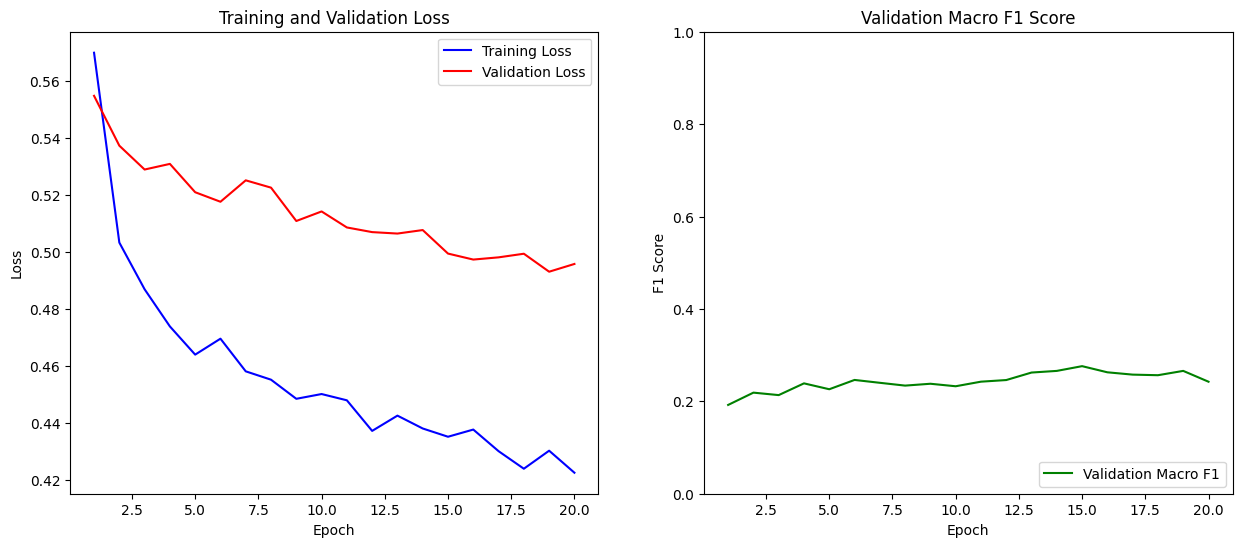


Generating Confusion Matrix for Best Model (best_model_v3.pth)


Running final validation for CM: 100%|██████████| 14/14 [00:36<00:00,  2.57s/it]


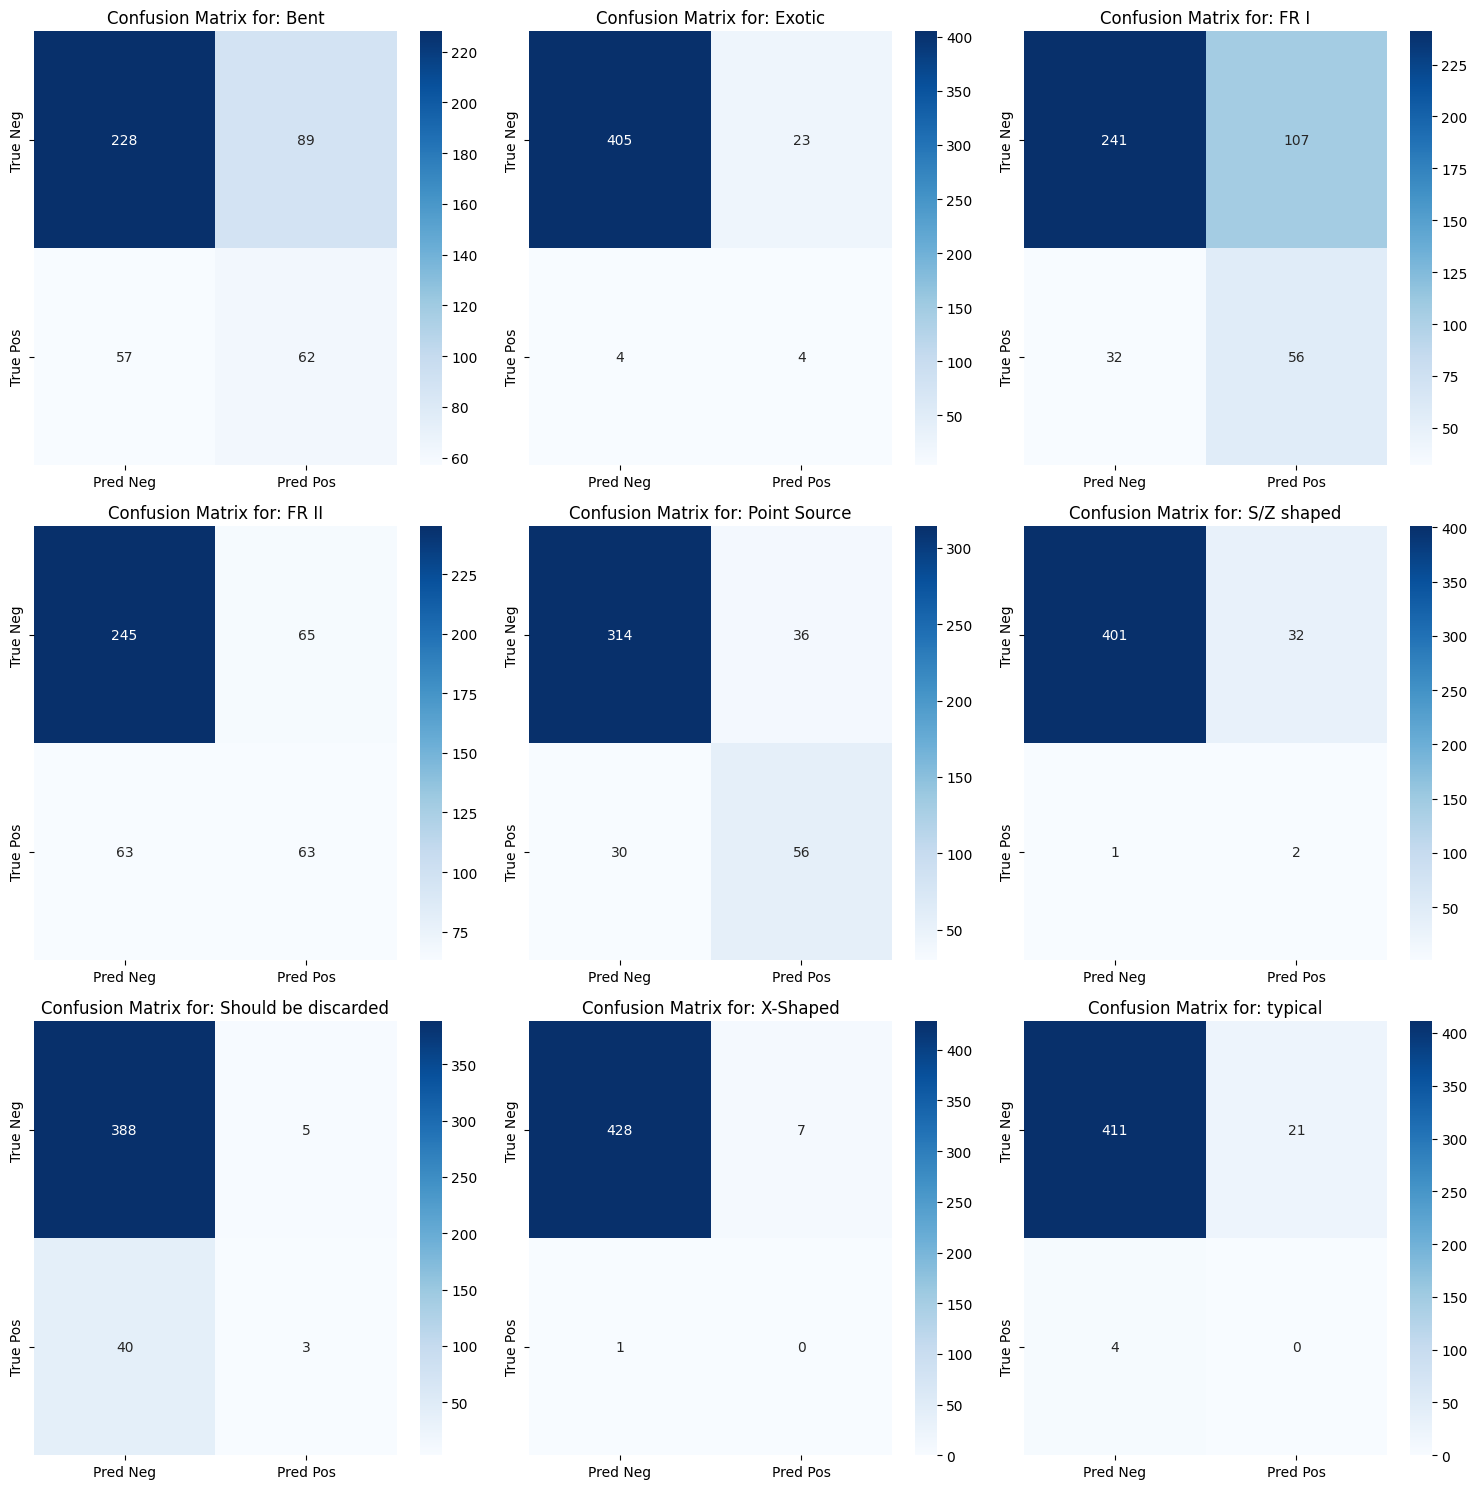

In [ ]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchmetrics

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import multilabel_confusion_matrix
from tqdm import tqdm
import pandas as pd


df = pd.read_csv(LABELS_FILE)
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)


train_dataset = RadioSourceDataset(train_df, IMAGE_ROOT_DIR, transform=train_transform)
val_dataset = RadioSourceDataset(val_df, IMAGE_ROOT_DIR, transform=val_transform)


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("\n--- Starting Training (on unzipped files) ---")

best_val_f1 = 0.0
model_save_path = "best_model_v3.pth"


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(NUM_CLASSES).to(DEVICE)
pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float32).to(DEVICE)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
f1_metric = torchmetrics.F1Score(task="multilabel", num_labels=NUM_CLASSES, average='macro').to(DEVICE)


train_loss_history = []
val_loss_history = []
val_f1_history = []


for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)


    model.eval()
    val_loss = 0.0
    f1_metric.reset()

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs)
            f1_metric.update(preds, labels.int())

    val_loss /= len(val_loader.dataset)
    val_f1 = f1_metric.compute()

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Macro F1: {val_f1:.4f}")


    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append(val_f1.cpu().item())

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), model_save_path)
        print(f"*** New best model saved to {model_save_path} (F1: {best_val_f1:.4f}) ***")

print("\n--- Training Complete ---")
print(f"Best validation Macro F1 score: {best_val_f1:.4f}")
print(f"Best model weights saved to {model_save_path}")


print("\n--- Plotting Training Performance ---")
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs_range, val_loss_history, 'r-', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_f1_history, 'g-', label='Validation Macro F1')
plt.legend(loc='lower right')
plt.title('Validation Macro F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(0, 1)

plt.show()


print("\n" + "="*50)
print(f"Generating Confusion Matrix for Best Model ({model_save_path})")
print("="*50)


model = create_model(NUM_CLASSES)
model.load_state_dict(torch.load(model_save_path, map_location=DEVICE))
model.to(DEVICE)
model.eval()

all_preds_binary = []
all_labels = []

with torch.no_grad():

    for images, labels in tqdm(val_loader, desc="Running final validation for CM"):
        images = images.to(DEVICE)

        logits = model(images)
        probs = torch.sigmoid(logits)
        preds_binary = (probs > 0.5).cpu().numpy().astype(int)

        all_preds_binary.extend(preds_binary)
        all_labels.extend(labels.cpu().numpy().astype(int))

all_preds_binary = np.array(all_preds_binary)
all_labels = np.array(all_labels)

ml_cm = multilabel_confusion_matrix(all_labels, all_preds_binary)


num_classes = len(CLASS_NAMES)

n_cols = 3
n_rows = (num_classes + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, (matrix, name) in enumerate(zip(ml_cm, CLASS_NAMES)):
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Neg', 'Pred Pos'],
                yticklabels=['True Neg', 'True Pos'],
                ax=axes[i])
    axes[i].set_title(f'Confusion Matrix for: {name}')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

Creating directory /content/images_unl/
Unzipping unl.zip...
Unzipping complete.
Using device: cpu
Loaded 9 classes: ['Bent', 'Exotic', 'FR I', 'FR II', 'Point Source', 'S/Z shaped', 'Should be discarded', 'X-Shaped', 'typical']
--- Generating generated_labels_FULL.csv ---
Scanning all subfolders in /content/images_unl/...
Found 13821 images. (Expected: 13821)
Loading model from best_model_v3.pth...
Model loaded.


Generating Predictions: 100%|██████████| 216/216 [21:05<00:00,  5.86s/it]


Formatting submission file...

Successfully saved predictions to 'generated_labels_FULL.csv'
Total labels generated: 13821
--- Head of submission file ---
         0       1       2     3     4     5     6     7     8
0    9.783  -9.715   FR II  None  None  None  None  None  None
1  263.160 -82.415    FR I  None  None  None  None  None  None
2  358.389 -25.623    Bent  FR I  None  None  None  None  None
3  144.152 -75.731  Exotic  None  None  None  None  None  None
4  107.205 -59.935    None  None  None  None  None  None  None

Generating Visualizations for Unlabelled Set
Plotting predicted label distribution...


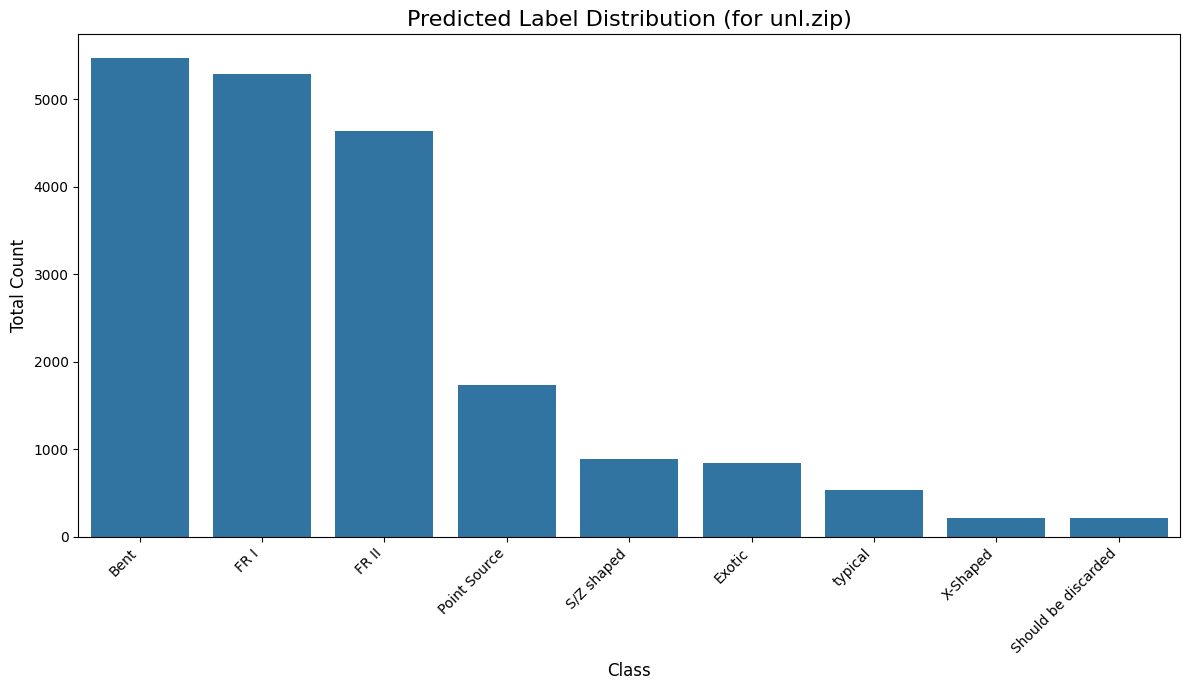


Plotting sample predictions...


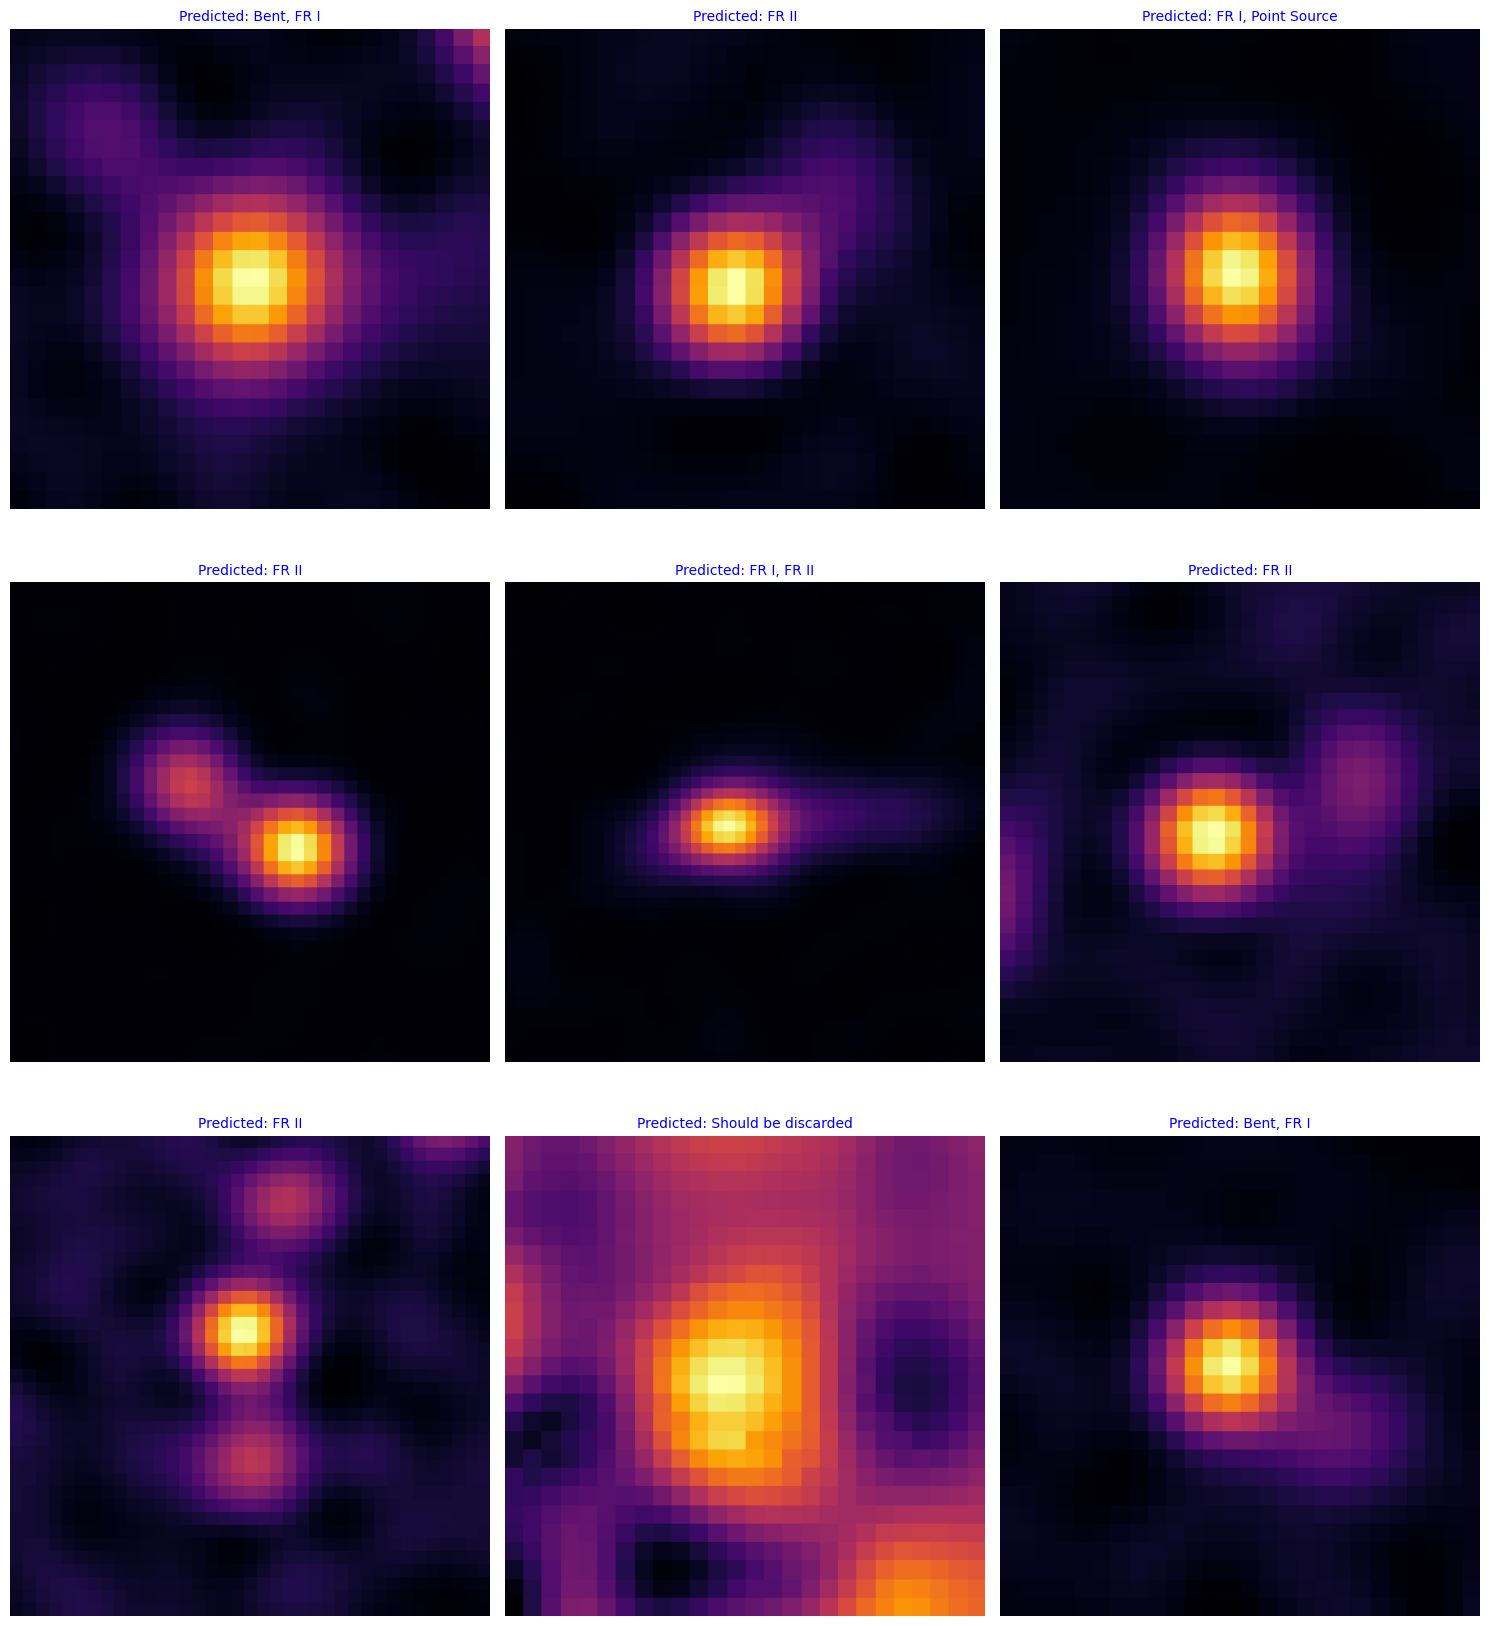

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import re
import timm
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


UNL_DIR = '/content/images_unl/'
UNL_ZIP = 'unl.zip'
if not os.path.exists(UNL_DIR):
    print(f"Creating directory {UNL_DIR}")
    os.makedirs(UNL_DIR, exist_ok=True)
    print(f"Unzipping {UNL_ZIP}...")
    !unzip -q {UNL_ZIP} -d {UNL_DIR}
    print("Unzipping complete.")
else:
    print(f"Directory {UNL_DIR} already exists. Skipping unzip.")


def get_all_unl_images(unl_dir):
    """
    Robustly walks all subdirectories to find image files
    and parse their coordinates.
    """
    image_data = []
    coord_pattern = re.compile(r'^([\d\.-]+)\s([\d\.-]+)_\[.*\.png$')

    print(f"Scanning all subfolders in {unl_dir}...")
    for root, _, files in os.walk(unl_dir):
        for filename in files:
            if '.ipynb_checkpoints' in root or '__MACOSX' in root or not filename.endswith('.png'):
                continue
            match = coord_pattern.match(filename)
            if match:
                ra_str, dec_str = match.groups()
                try:
                    ra = float(ra_str)
                    dec = float(dec_str)
                    full_path = os.path.join(root, filename)
                    rel_path = os.path.relpath(full_path, unl_dir)
                    image_data.append((rel_path, ra, dec))
                except ValueError:
                    print(f"Warning: Could not parse coordinates from: {filename}")

    if not image_data:
        print("Error: No image files with valid coordinates found. Stopping.")
        return None

    image_df = pd.DataFrame(image_data, columns=['image_filepath', 'img_ra', 'img_dec'])
    print(f"Found {len(image_df)} images. (Expected: 13821)")
    return image_df


MODEL_FILE = 'best_model_v3.pth'
UNL_MAP_FILE = 'unl_images_to_predict_FULL.csv'
SUBMISSION_FILE = 'generated_labels_FULL.csv'

IMG_SIZE = 224
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


temp_df = pd.read_csv('cleaned_labels.csv')
id_cols = ['image_filepath', 'label_ra', 'label_dec', 'match_distance']
CLASS_NAMES = [col for col in temp_df.columns if col not in id_cols]
NUM_CLASSES = len(CLASS_NAMES)
del temp_df
print(f"Loaded {NUM_CLASSES} classes: {CLASS_NAMES}")


def create_model(num_classes):
    model = timm.create_model('efficientnet_b0', pretrained=False)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model


class UnlRadioSourceDataset(Dataset):
    def __init__(self, df, image_root_dir, transform=None):
        self.df = df
        self.image_root_dir = image_root_dir
        self.transform = transform
        self.filepaths = df['image_filepath'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        full_path = os.path.join(self.image_root_dir, img_path)
        try:
            img = Image.open(full_path).convert('RGB')
        except Exception as e:
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')
        if self.transform:
            img = self.transform(img)
        return img


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize,
])


print(f"--- Generating {SUBMISSION_FILE} ---")

unl_map_df = get_all_unl_images(UNL_DIR)
if unl_map_df is not None:
    unl_map_df.to_csv(UNL_MAP_FILE, index=False)

    print(f"Loading model from {MODEL_FILE}...")
    model = create_model(NUM_CLASSES)
    model.load_state_dict(torch.load(MODEL_FILE, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    print("Model loaded.")

    unl_dataset = UnlRadioSourceDataset(unl_map_df, UNL_DIR, transform=val_transform)
    unl_loader = DataLoader(unl_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    all_preds_binary = []
    with torch.no_grad():
        for images in tqdm(unl_loader, desc="Generating Predictions"):
            images = images.to(DEVICE)
            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).cpu().numpy().astype(int)
            all_preds_binary.extend(preds)

    print("Formatting submission file...")
    preds_array = np.array(all_preds_binary)
    coordinates = unl_map_df[['img_ra', 'img_dec']].values
    submission_data = []

    for (ra, dec), binary_preds in zip(coordinates, preds_array):
        predicted_labels = [CLASS_NAMES[i] for i, val in enumerate(binary_preds) if val == 1]
        row = [ra, dec] + predicted_labels
        submission_data.append(row)

    submission_df = pd.DataFrame(submission_data)
    submission_df.to_csv(SUBMISSION_FILE, header=False, index=False)

    print(f"\nSuccessfully saved predictions to '{SUBMISSION_FILE}'")
    print(f"Total labels generated: {len(submission_df)}")
    print("--- Head of submission file ---")
    print(submission_df.head())



    print("\n" + "="*50)
    print("Generating Visualizations for Unlabelled Set")
    print("="*50)


    print("Plotting predicted label distribution...")


    id_vars = [0, 1]
    label_cols = [col for col in submission_df.columns if col not in id_vars]

    if not label_cols:
        print("Warning: Model did not predict any labels.")
    else:
        melted_df = submission_df.melt(
            id_vars=id_vars,
            value_vars=label_cols,
            value_name='label'
        ).dropna(subset=['label'])

        label_counts = melted_df['label'].value_counts()

        plt.figure(figsize=(12, 7))
        sns.barplot(x=label_counts.index, y=label_counts.values, order=label_counts.index)
        plt.title('Predicted Label Distribution (for unl.zip)', fontsize=16)
        plt.ylabel('Total Count', fontsize=12)
        plt.xlabel('Class', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()



    print("\nPlotting sample predictions...")

    def format_labels(binary_vec, names):
        labels = [names[i] for i, val in enumerate(binary_vec) if val == 1]
        if not labels:
            return "None"
        return ", ".join(labels)


    sample_indices = np.random.choice(len(unl_map_df), 9, replace=False)

    fig, axes = plt.subplots(3, 3, figsize=(15, 17))
    axes = axes.flatten()

    for i, idx in enumerate(sample_indices):

        filepath = unl_map_df.iloc[idx]['image_filepath']
        full_path = os.path.join(UNL_DIR, filepath)


        binary_preds = preds_array[idx]
        pred_labels_str = format_labels(binary_preds, CLASS_NAMES)

        try:
            img = Image.open(full_path).convert('RGB')
        except Exception:
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')

        ax = axes[i]
        ax.imshow(img, cmap='gray')
        ax.set_title(f"Predicted: {pred_labels_str}", color='blue', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

else:
    print("Could not find any unlabelled images. Pipeline stopped.")

Using device: cpu
Loaded 9 classes: ['Bent', 'Exotic', 'FR I', 'FR II', 'Point Source', 'S/Z shaped', 'Should be discarded', 'X-Shaped', 'typical']
Loading and processing pseudo-labels...
Loaded 13821 pseudo-labeled samples.
Original training samples: 1742
Pseudo-labeled samples: 13821
Total combined training samples: 15563
Validation samples (unchanged): 436

--- Starting Pseudo-Label Fine-Tuning ---


Epoch 1/10 [Val]: 100%|██████████| 14/14 [00:23<00:00,  1.71s/it]


Epoch 1/10 - Train Loss: 0.4636 - Val Loss: 0.5916 - Val Macro F1: 0.2749
*** New best model saved to best_model_v4_pseudo.pth (F1: 0.2749) ***


Epoch 2/10 [Val]: 100%|██████████| 14/14 [00:25<00:00,  1.81s/it]


Epoch 2/10 - Train Loss: 0.4050 - Val Loss: 0.6153 - Val Macro F1: 0.2755
*** New best model saved to best_model_v4_pseudo.pth (F1: 0.2755) ***


Epoch 3/10 [Val]: 100%|██████████| 14/14 [00:24<00:00,  1.76s/it]


Epoch 3/10 - Train Loss: 0.3865 - Val Loss: 0.6346 - Val Macro F1: 0.2776
*** New best model saved to best_model_v4_pseudo.pth (F1: 0.2776) ***


Epoch 4/10 [Val]: 100%|██████████| 14/14 [00:26<00:00,  1.86s/it]


Epoch 4/10 - Train Loss: 0.3741 - Val Loss: 0.6129 - Val Macro F1: 0.2886
*** New best model saved to best_model_v4_pseudo.pth (F1: 0.2886) ***


Epoch 5/10 [Val]: 100%|██████████| 14/14 [00:24<00:00,  1.75s/it]


Epoch 5/10 - Train Loss: 0.3700 - Val Loss: 0.6384 - Val Macro F1: 0.2685


Epoch 6/10 [Val]: 100%|██████████| 14/14 [00:25<00:00,  1.79s/it]


Epoch 6/10 - Train Loss: 0.3648 - Val Loss: 0.6235 - Val Macro F1: 0.2844


Epoch 7/10 [Val]: 100%|██████████| 14/14 [00:27<00:00,  1.94s/it]


Epoch 7/10 - Train Loss: 0.3573 - Val Loss: 0.6404 - Val Macro F1: 0.2777


Epoch 8/10 [Val]: 100%|██████████| 14/14 [00:26<00:00,  1.89s/it]


Epoch 8/10 - Train Loss: 0.3561 - Val Loss: 0.6377 - Val Macro F1: 0.2840


Epoch 9/10 [Val]: 100%|██████████| 14/14 [00:28<00:00,  2.01s/it]


Epoch 9/10 - Train Loss: 0.3522 - Val Loss: 0.6530 - Val Macro F1: 0.2808


Epoch 10/10 [Val]: 100%|██████████| 14/14 [00:26<00:00,  1.90s/it]


Epoch 10/10 - Train Loss: 0.3467 - Val Loss: 0.6389 - Val Macro F1: 0.2851

--- Pseudo-Label Training Complete ---
Best validation Macro F1 score: 0.2886
Final model weights saved to best_model_v4_pseudo.pth

--- Plotting Final Training Performance ---


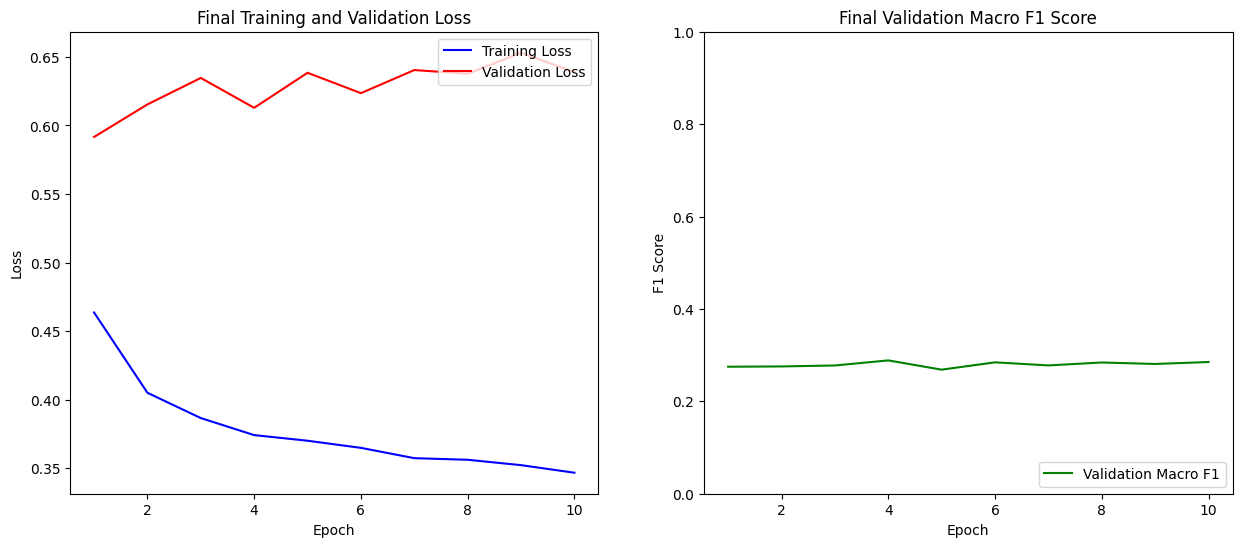

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
from PIL import Image
import os
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchmetrics


MANUAL_LABELS_FILE = 'cleaned_labels.csv'
PSEUDO_LABELS_FILE = 'generated_labels_FULL.csv'
UNL_MAP_FILE = 'unl_images_to_predict_FULL.csv'


IMAGE_ROOT_DIR_LBL = '/content/images/'
IMAGE_ROOT_DIR_UNL = '/content/images_unl/'


MODEL_TO_FINETUNE = 'best_model_v3.pth'
FINAL_MODEL_SAVE_PATH = 'best_model_v4_pseudo.pth'


IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-5


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


temp_df = pd.read_csv(MANUAL_LABELS_FILE)
id_cols = ['image_filepath', 'label_ra', 'label_dec', 'match_distance']
CLASS_NAMES = [col for col in temp_df.columns if col not in id_cols]
NUM_CLASSES = len(CLASS_NAMES)
del temp_df
print(f"Loaded {NUM_CLASSES} classes: {CLASS_NAMES}")


print("Loading and processing pseudo-labels...")
unl_map_df = pd.read_csv(UNL_MAP_FILE)


pseudo_df = pd.read_csv(PSEUDO_LABELS_FILE, header=None)
pseudo_df = pseudo_df.rename(columns={0: 'img_ra', 1: 'img_dec'})


id_vars = ['img_ra', 'img_dec']
label_cols = [col for col in pseudo_df.columns if col not in id_vars]

if not label_cols:
    print("Warning: Your pseudo-label file appears to have no labels.")
    pseudo_hot_df = pd.DataFrame(columns=['img_ra', 'img_dec'] + CLASS_NAMES)
else:
    long_df = pd.melt(pseudo_df, id_vars=id_vars, value_vars=label_cols, value_name='label').dropna(subset=['label'])

    encoded_df = pd.get_dummies(long_df, columns=['label'], prefix='', prefix_sep='')

    pseudo_hot_df = encoded_df.groupby(['img_ra', 'img_dec']).sum().reset_index()


pseudo_hot_df['img_ra_round'] = pseudo_hot_df['img_ra'].round(5)
unl_map_df['img_ra_round'] = unl_map_df['img_ra'].round(5)
pseudo_hot_df['img_dec_round'] = pseudo_hot_df['img_dec'].round(5)
unl_map_df['img_dec_round'] = unl_map_df['img_dec'].round(5)

final_pseudo_df = pd.merge(
    unl_map_df,
    pseudo_hot_df,
    on=['img_ra_round', 'img_dec_round'],
    how='left',
    suffixes=('_map', '_pseudo')
)


for col in CLASS_NAMES:
    if col not in final_pseudo_df.columns:
        final_pseudo_df[col] = 0

final_pseudo_df[CLASS_NAMES] = final_pseudo_df[CLASS_NAMES].fillna(0).astype(int)


final_pseudo_df = final_pseudo_df[['image_filepath'] + CLASS_NAMES]
print(f"Loaded {len(final_pseudo_df)} pseudo-labeled samples.")


class RadioSourceDataset(Dataset):
    def __init__(self, df, image_root_dir, transform=None):
        self.df = df
        self.image_root_dir = image_root_dir
        self.transform = transform
        self.labels = df[CLASS_NAMES].values
        self.filepaths = df['image_filepath'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        full_path = os.path.join(self.image_root_dir, img_path)
        try:
            img = Image.open(full_path).convert('RGB')
        except Exception as e:
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), color='black')

        label = self.labels[idx]
        if self.transform:
            img_tensor = self.transform(img)
        else:
            img_tensor = transforms.ToTensor()(img)

        label_tensor = torch.tensor(label, dtype=torch.float32)
        return img_tensor, label_tensor


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    normalize,
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    normalize,
])


df_labeled = pd.read_csv(MANUAL_LABELS_FILE)
train_df, val_df = train_test_split(df_labeled, test_size=0.2, random_state=42)
original_train_dataset = RadioSourceDataset(train_df, IMAGE_ROOT_DIR_LBL, transform=train_transform)
val_dataset = RadioSourceDataset(val_df, IMAGE_ROOT_DIR_LBL, transform=val_transform)

pseudo_dataset = RadioSourceDataset(final_pseudo_df, IMAGE_ROOT_DIR_UNL, transform=train_transform)


combined_train_dataset = ConcatDataset([original_train_dataset, pseudo_dataset])

print(f"Original training samples: {len(original_train_dataset)}")
print(f"Pseudo-labeled samples: {len(pseudo_dataset)}")
print(f"Total combined training samples: {len(combined_train_dataset)}")
print(f"Validation samples (unchanged): {len(val_dataset)}")


train_loader = DataLoader(combined_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


def create_model(num_classes):
    model = timm.create_model('efficientnet_b0', pretrained=False)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model


model = create_model(NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_TO_FINETUNE, map_location=DEVICE))
model.to(DEVICE)


pos_counts = train_df[CLASS_NAMES].sum()
neg_counts = len(train_df)
pos_weight = (neg_counts / (pos_counts + 1e-6)) ** 0.5
pos_weight_tensor = torch.tensor(pos_weight.values, dtype=torch.float32).to(DEVICE)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
f1_metric = torchmetrics.F1Score(task="multilabel", num_labels=NUM_CLASSES, average='macro').to(DEVICE)

print("\n--- Starting Pseudo-Label Fine-Tuning ---")
best_val_f1 = 0.0


train_loss_history = []
val_loss_history = []
val_f1_history = []

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)


    model.eval()
    val_loss = 0.0
    f1_metric.reset()

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            preds = torch.sigmoid(outputs)
            f1_metric.update(preds, labels.int())

    val_loss /= len(val_loader.dataset)
    val_f1 = f1_metric.compute()


    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    val_f1_history.append(val_f1.cpu().item())

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {train_loss:.4f} - "
          f"Val Loss: {val_loss:.4f} - "
          f"Val Macro F1: {val_f1:.4f}")

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), FINAL_MODEL_SAVE_PATH)
        print(f"*** New best model saved to {FINAL_MODEL_SAVE_PATH} (F1: {best_val_f1:.4f}) ***")

print("\n--- Pseudo-Label Training Complete ---")
print(f"Best validation Macro F1 score: {best_val_f1:.4f}")
print(f"Final model weights saved to {FINAL_MODEL_SAVE_PATH}")


print("\n--- Plotting Final Training Performance ---")
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs_range, val_loss_history, 'r-', label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Final Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_f1_history, 'g-', label='Validation Macro F1')
plt.legend(loc='lower right')
plt.title('Final Validation Macro F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()